In [2]:
import sys
sys.path.insert(0, '/home/ashwin1996/FLD_optimal_weighting')

import numpy as np
import mne
from mne import preprocessing

from scipy import signal
from tfld import utils, tfld

import matplotlib.pyplot as plt

# from libci import utils

import pyxdf

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd

from sklearn.decomposition import PCA
from joblib import delayed, Parallel

%load_ext autoreload
%autoreload 2

from joblib import Parallel, delayed
from tfld import tfld
from tqdm import tqdm

In [3]:
def train_fld(X, y, cov=None):
    "Train the FLD on the target data (return the learnt projection vector, covariance estimate, and target class 1 mean (nu^(0)) estimate"
    X_1 = X[y==1]
    X_0 = X[y==0]

    # estimate class means
    m_0 = np.mean(X_0, axis=0)
    m_1 = np.mean(X_1, axis=0)

    # estimate class covariance matrices
    if cov is None:
        n_0, n_1 = len(X_0), len(X_1)
        cov_0 = np.cov(X_0, rowvar=False)
        cov_1 = np.cov(X_1, rowvar=False)
        cov = ((n_0 - 1) * cov_0 + (n_1 - 1) * cov_1) / (n_0 + n_1 - 2) # pooled variance
    
    # estimate class priors
    p = len(y[y==1])/len(y)

    # estimate projection and threshold terms
    w_0 = np.linalg.pinv(2 * cov) @ (m_1 - m_0)
    w_0 /= np.linalg.norm(w_0)
    c_0 = 2 * np.log((1-p)/p)
    nu_hat = (m_1 - m_0)/2

    return w_0, c_0, cov, nu_hat 

def compute_expected_risk(w_alpha, Sigma_t, nu):
    "Compute the expected accuracy of the combined hypothesis analytically"
    w_alpha = np.expand_dims(w_alpha, -1)
    nom = - w_alpha.T @ nu
    denom = np.sqrt(w_alpha.T @ Sigma_t @ w_alpha)
    risk = norm.cdf(nom / denom)
    return risk


def get_source_std_error(w_s):
    "Compute the estimated standard error of the average source projection vector"
    avg_ws = np.mean(w_s, axis=0)
    R = np.linalg.norm(avg_ws)
    avg_ws /= R
    J = len(w_s)
    d = 1 - np.mean((avg_ws @ w_s.T)**2)
    sigma = np.sqrt(d / (J * R**2))
    return sigma**2 * np.eye(w_s.shape[1])

In [4]:
dir_ = '/home/ashwin1996/FLD_optimal_weighting/data/physionet.org/files/eegmat/1.0.0/'

meta = pd.read_csv(dir_ + 'subject-info.csv')
meta.head()

,Subject,Age,Gender,Recording year,Number of subtractions,Count quality
0,Subject00,21,F,2011,9.70,0
1,Subject01,18,F,2011,29.35,1
2,Subject02,19,F,2012,12.88,1
3,Subject03,17,F,2010,31.00,1
4,Subject04,17,F,2010,8.60,0


In [ ]:
subject_labels = np.array(list(meta['Count quality']))
gender = np.array(list(meta['Gender']))
recording_year = np.array(list(meta['Recording year']))

raw_edfs = utils.get_raw_edfs(dir_)

raw_edfs = [r.drop_channels(['ECG ECG', 'EEG A2-A1']) for r in raw_edfs]
raw_edfs = [r.rename_channels(lambda x: x.split(' ')[-1]) for r in raw_edfs]
    
montage = mne.channels.make_standard_montage(kind='standard_1020')

infos = [r.set_montage(montage, on_missing='ignore') for r in raw_edfs]
infos = [r.load_data().set_eeg_reference(ref_channels='average') for r in infos]
infos = [r.filter(0.5, 30) for r in infos]

channel_names = infos[0].ch_names

print(channel_names)

In [6]:
sfreq=500

channel_names_to_keep =  np.array([c for c in channel_names if 'z' in c.lower()])
channels_to_keep = np.array([i for i, c in enumerate(channel_names) if 'z' in c.lower()])

nspw=2.5
windowed = utils.get_time_windows([r.get_data()[channels_to_keep] for r in infos], sfreq=sfreq, n_seconds_per_window=nspw, n_seconds_overlap=0)

bands = [[4,8], [8,12], [12,20]]
psd = utils.get_power_spectrum_ratio(windowed, sfreq, bands)
psd = [p / np.sum(p, axis=-1, keepdims=True) for p in psd]

concat = utils.concatenate_features(psd, axes=[-2,-1])

X = [np.concatenate((concat[i], concat[i+1])) for i in range(0, len(concat), 2)]
y = [np.concatenate((i * np.ones(concat[i].shape[0]), (i+1) * np.ones(concat[i+1].shape[0]))) for i in range(0, len(concat), 2)]
y = [t.astype(int) % 2 for t in y]

In [16]:
from sklearn.metrics import balanced_accuracy_score as bas
from scipy.linalg import polar

def cross_subject_experiment(X, y, p, traget_index=0, grid=0.1, n_samples_to_estimate_risk=100, bootstrap_variance=False,
                             remove_tasks=False, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    assert len(X) == len(y)
    n_tasks = len(X)
            
    # make target task projection vectors == [+/-1, 0_{d-1}]
    
    train_inds = [tfld.even_sample_inds(y_, p=1) for y_ in y]
    scalers = [tfld.TranslateStandardScale().fit(X[i][train_inds[i]], y[i][train_inds[i]]) for i in range(n_tasks)]
    
    projections = []
    covs = []
    for i in range(n_tasks):
        X_ = scalers[i].transform(X[i])
        target_vector, threshold, pooled_cov, class_1_mean = train_fld(X_, y[i])
        covs.append(pooled_cov)
        projections.append(target_vector)
        
    accuracies = np.zeros((1, 5))
    alphas = np.zeros((1, 2))
                                    
    train_inds = tfld.even_sample_inds(y[traget_index], p=p)
    print(train_inds)
    scaler = tfld.TranslateStandardScale().fit(X[traget_index][train_inds], y[traget_index][train_inds])
    
    X_ = scaler.transform(X[traget_index])
    target_vector, threshold, pooled_cov, class_1_mean = train_fld(X_[train_inds], y[traget_index][train_inds])  

    #- average-source projection vector
    indices_to_include = np.array([j for j in range(n_tasks) if j not in [traget_index]])
    source_projs = [projections[j] for j in indices_to_include]
    average_source_vector = tfld.estimate_mu(source_projs)


    optimal_alpha = tfld.get_optimal_alpha(len(train_inds), class_1_mean, source_projs, 
                                            grid, n_samples_to_estimate_risk=n_samples_to_estimate_risk, 
                                            cov=pooled_cov, variance_from_target=None, variance_from_combined=None)
    optimal_proj = optimal_alpha * target_vector + (1 - optimal_alpha) * average_source_vector
        
        
    alphas[0,0] = optimal_alpha
    
    #- oracle projection vector
    test = [j for j in range(len(X[traget_index])) if j not in train_inds]
    
    oracle_alpha = utils.get_oracle_alpha(X_[test], y[traget_index][test], target_vector, average_source_vector, h=grid)
    oracle_proj = oracle_alpha * target_vector + (1 - oracle_alpha) * average_source_vector
    alphas[0,1] = oracle_alpha
    
    #- Evaluation
    pred = (X_[test] @ target_vector >= 0).astype(int)
    accuracies[0, 0] = bas(y[traget_index][test], pred)

    pred = (X_[test] @ average_source_vector >= 0).astype(int)
    accuracies[0, 1] = bas(y[traget_index][test], pred)
    
    pred = (X_[test] @ optimal_proj >= 0).astype(int)
    accuracies[0, 2] = bas(y[traget_index][test], pred)
    
    pred = (X_[test] @ oracle_proj >= 0).astype(int)
    accuracies[0, 3] = bas(y[traget_index][test], pred)
    
    random_accuracies = np.zeros(100)
    for j in range(100):
        random_alpha = np.random.choice(np.arange(0,1+grid, grid), size=1)[0]
        random_proj = random_alpha * target_vector + (1 - random_alpha) * average_source_vector
        pred = (X_[test] @ random_proj >= 0).astype(int)
        random_accuracies[j] = bas(y[traget_index][test], pred)
        
    accuracies[0, 4] = np.mean(random_accuracies)
    
    return accuracies, alphas

In [27]:
# obtain the gold standard
np.random.seed(1)

n_mc = 1
B = 100000
n_jobs = 30
p_list = [0.05, 0.1, 0.2]

accuracies = np.zeros((len(p_list), n_mc, 1, 5))
alphas = np.zeros((len(p_list), n_mc, 1, 2))
for i, p in enumerate(tqdm(p_list)):
    f = lambda x: cross_subject_experiment(X, y, p, grid=0.1, n_samples_to_estimate_risk=B, acorn=1996)
    
    results = Parallel(n_jobs=30)(delayed(f)(x) for x in np.zeros(n_mc))
    
    for j, (accuracy, alpha) in enumerate(results):
        accuracies[i,j] = accuracy
        alphas[i,j] = alpha
    
    print(i, np.mean(np.mean(accuracies, axis=1), axis=1)[i])

  0%|          | 0/3 [00:00<?, ?it/s]

[49 41 89 79]


 33%|███▎      | 1/3 [02:27<04:54, 147.23s/it]

0 [0.34537661 0.64360073 0.34537661 0.64360073 0.50106859]
[49 41  1 89 79 96]


 67%|██████▋   | 2/3 [04:49<02:24, 144.16s/it]

1 [0.66623377 0.66103896 0.66623377 0.70649351 0.68975974]
[49 41  1  4 25 89 79 96 85 81]


100%|██████████| 3/3 [07:12<00:00, 144.10s/it]

2 [0.48823529 0.65882353 0.59705882 0.65882353 0.59597059]


In [28]:
accuracies_ = accuracies.squeeze()
alphas_ = alphas.squeeze()
np.save("gold_std_accuracies.npy", accuracies_)
np.save("gold_std_alphas.npy", alphas_)

In [29]:
# run the experiment
np.random.seed(1)

B_list = [10, 50, 100, 500, 1000, 5000]

accuracies = np.zeros((len(p_list), len(B_list), n_mc, 1, 5))
alphas = np.zeros((len(p_list), len(B_list), n_mc, 1, 2))

for i, p in enumerate(p_list):
    for j, B in enumerate(B_list):
        print("p = {}, B = {}".format(p, B))
        f = lambda x: cross_subject_experiment(X, y, p, grid=0.1, n_samples_to_estimate_risk=B, acorn=1996)
        
        results = Parallel(n_jobs=30)(delayed(f)(x) for x in np.zeros(n_mc))
        
        for k, (accuracy, alpha) in enumerate(results):
            accuracies[i,j,k] = accuracy
            alphas[i,j,k] = alpha

p = 0.05, B = 10
[49 41 89 79]
p = 0.05, B = 50
[49 41 89 79]
p = 0.05, B = 100
[49 41 89 79]
p = 0.05, B = 500
[49 41 89 79]
p = 0.05, B = 1000
[49 41 89 79]
p = 0.05, B = 5000
[49 41 89 79]
p = 0.1, B = 10
[49 41  1 89 79 96]
p = 0.1, B = 50
[49 41  1 89 79 96]
p = 0.1, B = 100
[49 41  1 89 79 96]
p = 0.1, B = 500
[49 41  1 89 79 96]
p = 0.1, B = 1000
[49 41  1 89 79 96]
p = 0.1, B = 5000
[49 41  1 89 79 96]
p = 0.2, B = 10
[49 41  1  4 25 89 79 96 85 81]
p = 0.2, B = 50
[49 41  1  4 25 89 79 96 85 81]
p = 0.2, B = 100
[49 41  1  4 25 89 79 96 85 81]
p = 0.2, B = 500
[49 41  1  4 25 89 79 96 85 81]
p = 0.2, B = 1000
[49 41  1  4 25 89 79 96 85 81]
p = 0.2, B = 5000
[49 41  1  4 25 89 79 96 85 81]


In [32]:
accuracies = accuracies.squeeze()
alphas = alphas.squeeze()

mse_list = np.zeros((len(p_list), len(B_list)))
for i, p in enumerate(p_list):
    for j, B in enumerate(B_list):
        alphas_pB = alphas[i, j, 0].squeeze()
        alphas_p_ = alphas_[i, 0].squeeze()
        mse = np.sum((alphas_pB - alphas_p_)**2)
        # mse = abs(np.median(alphas_pB) - np.median(alphas_p_))
        mse_list[i, j] = mse

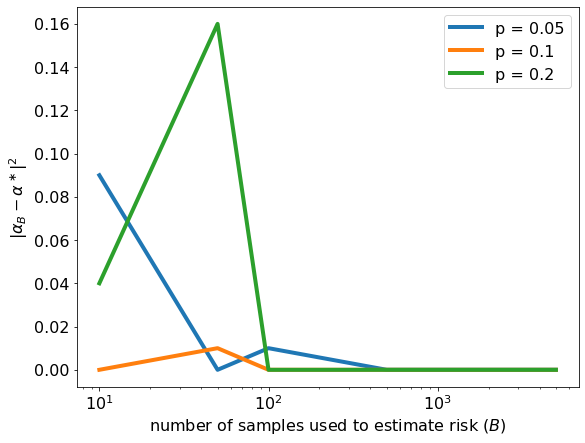

In [36]:
# plot
fig, ax = plt.subplots(figsize=(9, 7))
for i, p in enumerate(p_list):
    ax.plot(B_list, mse_list[i], label="p = {}".format(p), lw=4)
ax.set_xscale('log')
ax.legend(fontsize=16)
ax.set_ylabel(r"$\| \alpha_B - \alpha^\ast \|^2$", fontsize=16)
ax.set_xlabel(r"number of samples used to estimate risk ($B$)",fontsize=16)
ax.tick_params(labelsize=16)
